Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Visualization and Preprocessing of AirBnB Data

In [1]:
# Set-Up
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import datetime

In [2]:
# Load Data from CSV file as pandas dataframe
df = pd.read_csv('data/airbnb_train.csv')

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

## Business Understanding

This dataset is provided by Kaggle and aims to predict the price of AirBnb listings in major cities in the United States. Each record is one AirBnB listing from 2018 with 29 attributes that describe the listing and what it offers to guests. A linear regression model would be a strong choice for predicting the continuous value of the listing price. This model could be extremely beneficial for new AirBnb hosts to guide them in setting an initial price for their listings based on location, amenities, and other features that they offered with their listing. Furthermore, the price perdiction model could help ensure that AirBnb guests are not overcharged for their stay and that hosts are adequately compensated for their hospitality. The performance of this model would be measured by the root mean square error (RMSE) to determine how far predictions deviate from actual values. Using the RMSE metric is most appropriate within this context because it heavily penalizes large errors and we want to avoid significant prediction errors in listing prices.  


In addition, the rating score from the listing reviews is a potential variable of interest that can predict if a certain listing provided guests with a positive experience during their stay. AirBnB currently employs a "Superhost" program that rewards the hosts with the most experience and highest-rated reviews. A model aimed at classifying review rating scores could provide valuable insight into how AirBnB hosts could improve their hospitality standards and provide a better experience for their guests. It could also help new hosts better market their listings and attain superhost status. We would use misclassification rate as our performance evaluation metric with the goal of maximizing the classficiation accuracy for this type of model. A minimal misclassifcation error rate would adequately captures the attributes influencing highly-rated reviews and be useful to further our understanding of what consumers look for when searching for an AirBnb listing to book.

* **Recall vs. Precision?** I think we should prioritize recall for the context of this classification model.

# Quick snapshot of Data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

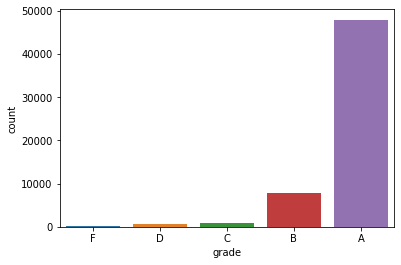

In [4]:
#Creating a categorical variable to predict based on the rating percentage
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

#Visuals
sns.countplot(df.grade)

In [5]:
df.groupby('grade').count()

id  log_price  property_type  room_type  amenities  accommodates  \
grade                                                                        
F        249        249            249        249        249           249   
D        598        598            598        598        598           598   
C        872        872            872        872        872           872   
B       7773       7773           7773       7773       7773          7773   
A      47897      47897          47897      47897      47897         47897   

       bathrooms  bed_type  cancellation_policy  cleaning_fee   city  \
grade                                                                  
F            249       249                  249           249    249   
D            596       598                  598           598    598   
C            869       872                  872           872    872   
B           7732      7773                 7773          7773   7773   
A          47784     47897                47897         47897  47897   

       description  first_review  host_has_profile_pic  \
grade                                                    
F              249           248                   249   
D              598           598                   597   
C              872           872                   869   
B             7773          7773                  7750   
A            47897         47897                 47783   

       host_identity_verified  host_response_rate  host_since  \
grade                                                           
F                         249                 162         249   
D                         597                 379         597   
C                         869                 717         869   
B                        7750                6337        7750   
A                       47783               40408       47783   

       instant_bookable  last_review  latitude  longitude   name  \
grade                                                              
F                   249          248       249        249    249   
D                   598          598       598        598    598   
C                   872          872       872        872    872   
B                  7773         7773      7773       7773   7773   
A                 47897        47897     47897      47897  47897   

       neighbourhood  number_of_reviews  review_scores_rating  thumbnail_url  \
grade                                                                          
F                210                249                   249            215   
D                534                598                   598            502   
C                771                872                   872            747   
B               7119               7773                  7773           6926   
A              43709              47897                 47897          43202   

       zipcode  bedrooms   beds  
grade                            
F          241       249    247  
D          592       598    595  
C          862       867    869  
B         7702      7765   7762  
A        47315     47840  47854

The data shows that the majority of these listings have been reviewed with a rating score of at least 80 on a scale of 100. Following the typical rating system employed by AirBnb, 75% of these listings were rated at least 4 out of 5 stars.
* 64.6% rated at least 90 out of 100
* 10.5% rated between 80-89 out of 100
* 1.2% rated between 70-79 out of 100
* 0.8% rated between 60-69 out of 100
* 0.3% rated between 0-59 out of 100

**Note: Not all listings in this dataset were given a rating score from reviews. This issue of missing data should be resolved before building a classification model for recommended listings.**

In [6]:
df['price'] = np.exp(df['log_price'])

The objective of the original Kaggle competition was to predict the target variable log(price). We have back-transformed this target variable to the original scale in terms of U.S. dollars ($) for easier interpretation of listing prices.

## Data Meaning Type

In [7]:
# Description of Dataset Variables (74111x29)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 31 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

This dataset originally contains 74,111 records and 29 columns. The addition of the 'grade' and 'price' variable brings the total number of columns to 31 variable.

In [8]:
# Summary Table describing each variable with its measurement scale, data type, brief interpretation of the attribute,
# and the percentage of missing data records

fig = go.Figure(data=[go.Table(
                    header = dict(values = ["Attribute","Measurement Scale",
                                            "Data Type","Description","%datamissing"],
                                  fill_color = 'paleturquoise',
                                  align = 'left'),
                    cells = dict(values = [df.columns, # Attributes
                        # Measurement Scale  
                        ["Nominal","Interval","Nominal","Nominal","Nominal","Interval","Interval",
                        "Nominal","Ordinal","Nominal","Nominal","Nominal","Ordinal","Nominal",
                        "Nominal","Ratio","Ordinal","Nominal","Ordinal","Interval","Interval",
                        "Nominal","Nominal","Interval","Ratio","Nominal","Nominal","Interval",
                        "Interval","Ordinal","Ratio"],
                        # Data Type                    
                        ["int64","float64","object","object","object","int64","float64","object","object",
                        "bool","object","object","datetime","bool","bool","float64","datetime","bool",
                        "datetime","float64","float64","object","object","int64","float64","object",
                        "object","int64","int64","category","float64"],
                        # Description
                        ["Unique Identifier for listing","natural logarithm of the listing price",
                        "The listing's property type (i.e. House, Apartment, Condominium, etc.)",
                        "The type of room provided by the listing (i.e. Private Room, Entire home/apt, etc.)",
                        "Amenities the listing provides (i.e. TV, WIFI, A/C, Parking, Kitchen, etc.)",
                        "Number of guests the listing can accomodate",
                        "Number of bathrooms the listing provides", 
                        "The type of beds the listing provides (i.e. Real Bed, Air Mattress, Futon, etc.)",
                        "Level of cancellation policy regarding refunds for reservations at the listing (i.e. flexible, moderate, strict)",
                        "Does the listing charge a cleaning fee? (i.e. True or False)",
                        "The United States city where the listing is located",
                        "A description of the listing provided by the host",
                        "The date of the listing's first review (e.g. 2017-01-01)",
                        "Does the listing's host provide a profile picture? (i.e. True or False)",
                        "Has the listing's host verified their identification with AirBnb? (i.e. True or False)",
                        "Host's response rate to all guest inquiries (i.e. 0-100%)",
                        "Date when host first listed their property with Airbnb (e.g. 2017-01-01)",
                        "Can the listing be instantly booked (i.e. True or False)",
                        "Date of the listing's last review from an AirBnb guest",
                        "Latitude Coordinates of the listing",
                        "Longitude Coordinates of the listing",
                        "The name identifying the listing in AirBnb property searches",
                        "The neighborhood in the United States where the listing is located",
                        "The number of reviews the listing has received from previous guests",
                        "The AirBnB rating score compiled from all the listing's reviews",
                        "The thumbnail url associated with the listing",
                        "The United States zipcode where the listing is located in",
                        "The number of bedrooms the listing provides",
                        "The number of beds the listing provides",
                        "The grade assigned to the listing based on its reviews rating score",
                        "The listing's price in U.S. dollars ($)"],
                        # %datamissing
                        ["0%","0%","0%","0%","0%","0%","0.3%","0%","0%","0%","0%","0%","21%",
                        "0.3%","0.3%","25%","0.3%","0%","21%","0%","0%","0%","9%","0%","23%",
                        "11%","1.3%","0.1%","0.2%","23%","0%"]],
                                 fill_color = 'lavender',
                                 align = 'left')
)])
fig.show()

AirBnb defines their Superhost program as system that rewards Airbnb hosts with the highest-rated reviews and most experience. It offers Superhosts enchanced opportunities to earn extra money, attract more guests, and access to exclusive rewards as incentive to continue providing exceptional hospitality to guests.

The requirements for Superhost eligibility are: a **4.8+ overall rating, 10+ stays, <1% cancellation rate, and 90% response rate**. This criteria establishes our baseline understanding for how these listings and hosts should be recommended to future AirBnb guests.

Given the unbalanced levels of the review rating scores as seen in the grade variable visualization, we will consider extracting a new binary response variable from the data with 96/100 as a potential cutoff threshold (4.8/5 overall stars). This value may be changed to optimize the classification model once we actually begin the training steps.

## Data Quality

We have decided to remove all instances with missing values for review_scores_rating (the variable we will be deriving our categorial response variable from) to avoid any complications introducted into a classification model by imputing values into the target response variable. This results in 57,389 listings remaining, and we believe a dataset of this size provides sufficient information to train a high-performing model.

In [9]:
df_ratings = df.dropna(subset=['review_scores_rating'])

**Variables with Float Data Types**
* log_price, latitude, longitude, review_scores_rating, price

**Variables with Integer Data Types**
* id, accomodates, bathrooms, number_of_reviews, bedrooms, beds

**Categortical Variables (Multiple levels/factors)**
* property_type, room_type, bed_type, cancellation_policy, city, neighbourhood, zipcode, grade

**Variables with Boolean Data Types**
* cleaning_fee, host_has_profile_pic, host_identity_verified

**Variables with Date-Time Data Types**
* first_review, host_since, last_review

**Variables with String Data Types**
* amenities (list of strings), description, name, thumbnail_url


In [10]:
# Data Type Manipulation
# Float Data Types
## Bathrooms is Interval Measurement Scale but Float Data Type to account for 1/2 bathrooms
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
# Drop % in host_response_rate values and transform to float value (100% = 1.0)
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100

# Int Data Types
## We are unable to transform the bedrooms and beds variables to an integer data type due to missing values
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
# df_ratings[ints][df_ratings[ints].notna()] = df_ratings[ints][df_ratings[ints].notna()].astype(np.int64)

# Datetime Types
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)

# Bool Types
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)

# Categorical Features
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')


C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df_ratings.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 74110
Data columns (total 31 columns):
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57230 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        48003 non-null float64
host_since                57248 non-null datetime64[ns]
instant_bookable          57389 non-null bool
last_rev

There were no duplicate records found after dropping all records with missing values for review_scores_rating.

Missing values for the neighbourhood, zipcode, and thumbnail_url attributes may have been the result of data scraping or collection errors. Since the city, latitude, and longitude variables do not contain missing values, we decided against imputing values for the neighbourhood and zipcode attributes to avoid introducing unnecessary complications into our model. We believe that the city, latitude, and longitude variables provide sufficient information pertaining to the location of the listing. As a result, we will potentially exclude the the neighbourhood and zipcode attributes when training our model. Furthemore, the thumbnail_url attribute does not provide much value in predicting either of our potential target response variables. We will not impute values for the missing data and will also exclude this attribute when training our model.

In [12]:
# Record with missing value for first_review and last_review
df_ratings[df_ratings.first_review.isna()]

id  log_price property_type     room_type  \
33984  7765579    4.59512         House  Private room   

                                               amenities  accommodates  \
33984  {TV,"Wireless Internet",Kitchen,"Free parking ...             2   

       bathrooms  bed_type cancellation_policy  cleaning_fee city  \
33984        1.0  Real Bed              strict          True  NYC   

                                             description first_review  \
33984  Our super comfortable, clean and cool room, wi...          NaT   

       host_has_profile_pic  host_identity_verified  host_response_rate  \
33984                  True                    True                 1.0   

      host_since  instant_bookable last_review   latitude  longitude  \
33984 2013-09-29             False         NaT  40.663137 -73.932994   

                          name  neighbourhood  number_of_reviews  \
33984  The Heights Rentals III  East Flatbush                  1   

       review_scores_rating  \
33984                  20.0   

                                           thumbnail_url  zipcode  bedrooms  \
33984  https://a0.muscache.com/im/pictures/632b80ab-d...  11203.0       1.0   

       beds grade  price  
33984   1.0     F   99.0

The record with the missing value for first_review and last_review is the same (id#33984 - Name: "The Heights Rentals III"). A closer look at this data record shows that it only has one review with a review_scores_rating of 20. Given that this dataset has been most recently updated in 2018 and the host originally listed the property on 2013-09-29, we have reason to believe that this AirBnb listing is no longer active and that those data values were inaccesible. We will consider dropping this record from the dataset when training our models.

In [13]:
# Impute Missing Values of host_since variable with first_review data value from same record
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We believe that the listings with missing values for the host_since variable may be the result of a host that has multiple AirBnB listings where the data value for this particular attribute is only associated with the first listing they originally began hosting through AirBnb. We found that a suitable strategy to address these missing values would be to impute them with the value from the first_review variable for that corresponding listing. The best estimate to minimize the loss of information from missing values of the host_since variable would be the date of the first review because these two attributes should be intuitively close in time. An imputation based on statistical averages such as mean, median, or mode would be arbitrary and may even conflict with the information provided from the first_review data value. For example, it would not make sense to impute a date for the host_since variable for a certain listing that is more recent in time than its first_review date value.

The missing values for the bathrooms, bedrooms, and beds attributes may have been a result of host input error. We believe that the hosts for these respective listings forgot to include this data when posting their property as an AirBnb listing. Thus, resulting in the omission of this information in the dataset for these certain listings. Based on our reasoning, we believed that the best imputation method for these missing values should be based on the property type and the number of guests the listing can accomodate. These variables generally provide a great determination of how many bathrooms, bedrooms, and beds are avaiable with the AirBnb listing. We decided to impute these missing values with the median because the mean value would not be a whole number and would thus not make sense in the context of bedrooms or beds.

In [14]:
# Code to determine missing values and imputation value for bathrooms by property type and accommodation number
## df_ratings[df_ratings.bathrooms.isna()].groupby(["property_type","accommodates"])["property_type"].count()
## df_ratings.groupby(["property_type","accommodates"])['bathrooms'].describe()

# Code to determine missing values and imputation value for bedrooms by property type and accommodation number
## df_ratings[df_ratings.bedrooms.isna()].groupby(["property_type","accommodates"])["property_type"].count()
## df_ratings.groupby(["property_type","accommodates"])['bedrooms'].median()

# Code to determine missing values and imputation value for beds by property type and accommodation number
## df_ratings[df_ratings.beds.isna()].groupby(["property_type","accommodates"])["property_type"].count()
## df_ratings.groupby(["property_type","accommodates"])['beds'].median()

In [15]:
# Impute Missing Values of Bathroom Variable
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Impute Missing Values for Bathrooms with median values based on Property Type & Accomodates**
* 159 missing values for bathrooms
    * Impute Apartments accommodating (1-5) w/ 1 bathroom (100 values)
    * Impute Bed & Breakfast accommodating (1-2) w/ 1 bathroom (3 values)
    * Impute Camper/RV accomodating 2 w/ 1 bathroom (1 value)
    * Impute Dorm accomodating (1-2) w/ 1 bathroom (8 values)
    * Impute House accomodating (1-4) w/ 1 bathroom (39 values)
    * Impute House accomodating 6 w/ 2 bathrooms (1 value)
    * Impute House accomodating 8 w/ 2.5 bathrooms (1 value)
    * Impute House accomodating 16 w/ 3 bathrooms (1 value)
    * Impute Loft accomodating 2 w/ 1 bathroom (1 value)
    * Impute Other accomodating (2-4) w/ 1 bathroom (4 values) 

In [16]:
# Impute Missing Values of Bedrooms Variable
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Impute Missing Values for Bedrooms with median values based on Property Type & Accomodates**
* 70 missing values for bedrooms
    * Impute Apartments accomodating (1-4) w/ 1 bedroom (57 values)
    * Impute Bungalow accomodating 3 w/ 1 bedroom (1 value)
    * Impute House accomodating 2 w/ 1 bedroom (7 values)
    * Impute House accomodating 6 w/ 3 bedroom (1 value)
    * Impute Loft accomodating 4 w/ 1 bedroom (3 values)
    * Impute Other accomodating 1 w/ 1 bedroom (1 value)

In [17]:
# Impute Missing Values of Beds Variable
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Impute Missing Values for Beds with median values based on Property Type & Accomodates**
* 62 missing values for beds
    * Impute Apartments accomodating (1-3) w/ 1 bed (38 values)
    * Impute Apartments accomoodating 4 w/ 2 beds (1 value)
    * Impute Condominium accomodating 2 w/ 1 bed (1 value)
    * Impute Dorm accomodating 1 w/ 1 bed (1 value)
    * Impute Guesthouse accomodating 1 w/ 1 bed (1 value)
    * Impute House accomodating (1-2) w/ 1 bed (14 values)
    * Impute House accomodating 3 w/ 2 beds (1 values)
    * Impute House accomodating 5 w/ 3 beds (1 value)
    * Impute House accomodating 16 w/ 8 beds (1 value)
    * Impute Other accomodating (1-2) w/ 1 bed (2 values)
    * Impute Townhouse accomodating 2 w/ 1 bed (1 value)

In [18]:
# Impute Missing Values of host_response_rate Variable
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We found that most of the missing values for the host_response_rate variable came from listings that only had a few reviews. This suggests that these first few guests may have not interacted with the host much so there is not enough information to provide data regarding the host_response_rate for these listings. We decided to impute these missing values with the mean based on the number of reviews and avoid using the review_rating_score data since it is a potential target variable we could predict.

In [19]:
# We can now change bedrooms and beds data type to integers now that we have addressed the missing values
df_imputed[ints] = df_imputed[ints].astype(np.int64)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57389 entries, 0 to 74110
Data columns (total 31 columns):
id                        57389 non-null int64
log_price                 57389 non-null float64
property_type             57389 non-null category
room_type                 57389 non-null category
amenities                 57389 non-null object
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
description               57389 non-null object
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57388 non-null float64
host_since                57389 non-null datetime64[ns]
instant_bookable          57389 non-null bool
last_rev

## Simple Statistics

In [20]:
df_imputed.describe()

id     log_price  accommodates     bathrooms  \
count  5.738900e+04  57389.000000  57389.000000  57389.000000   
mean   1.125208e+07      4.749232      3.218247      1.225967   
std    6.082797e+06      0.668700      2.144154      0.561473   
min    3.440000e+02      0.000000      1.000000      0.000000   
25%    6.248838e+06      4.304065      2.000000      1.000000   
50%    1.222387e+07      4.700480      2.000000      1.000000   
75%    1.639709e+07      5.164786      4.000000      1.000000   
max    2.123090e+07      7.600402     16.000000      8.000000   

       host_response_rate      latitude     longitude  number_of_reviews  \
count        57388.000000  57389.000000  57389.000000       57389.000000   
mean             0.952632     38.485767    -92.352714          26.957326   
std              0.122001      3.085702     21.670682          41.043449   
min              0.000000     33.338905   -122.511500           1.000000   
25%              0.940000     34.127760   -118.340924           3.000000   
50%              1.000000     40.668884    -76.995077          11.000000   
75%              1.000000     40.749182    -73.954325          33.000000   
max              1.000000     42.390437    -71.000261         605.000000   

       review_scores_rating      bedrooms          beds         price  
count          57389.000000  57389.000000  57389.000000  57389.000000  
mean              94.067365      1.260904      1.737546    147.748297  
std                7.836556      0.841280      1.265311    134.512852  
min               20.000000      0.000000      0.000000      1.000000  
25%               92.000000      1.000000      1.000000     74.000000  
50%               96.000000      1.000000      1.000000    110.000000  
75%              100.000000      1.000000      2.000000    175.000000  
max              100.000000     10.000000     18.000000   1999.000000

The above call provides summary statistics on all integer and float variables. For ID, latitude, and longitude, these are not particularly meaningful.

As aforementioned, log(price) was not easily interpretable and the log scale obscures some interesting details more readily apparent in the derived price variable. For one, the cheapest named price is one dollar. The actual cities where these postings were taken from, discussed in a later section, are typically expensive tourist destinations. Very cheap prices are not unheard of, and while this could be a data collection error, the other columns associated with the entry seem legitimate.

In [21]:
df_imputed.loc[df['price'] == 1]

id  log_price property_type    room_type  \
11632  17972519        0.0   Condominium  Shared room   

                                               amenities  accommodates  \
11632  {TV,"Wireless Internet","Air conditioning",Kit...             1   

       bathrooms  bed_type cancellation_policy  cleaning_fee city  \
11632        1.0  Real Bed              strict          True  NYC   

                                             description first_review  \
11632  Comfortable dwellings .. My comfy home is for ...   2017-08-17   

       host_has_profile_pic  host_identity_verified  host_response_rate  \
11632                  True                   False                 1.0   

      host_since  instant_bookable last_review   latitude  longitude  \
11632 2017-07-20              True  2017-10-01  40.838054 -73.858665   

                 name neighbourhood  number_of_reviews  review_scores_rating  \
11632  Esteem's Place   Parkchester                  3                  87.0   

                                           thumbnail_url zipcode  bedrooms  \
11632  https://a0.muscache.com/im/pictures/71bc085f-b...   10462         1   

       beds grade  price  
11632     1     B    1.0

In [22]:
df_imputed.loc[df['price'] > 1995].head(3)

id  log_price property_type        room_type  \
42672  16755372   7.600402     Apartment  Entire home/apt   
55453  14095274   7.600402     Townhouse  Entire home/apt   
61826  20230917   7.598399         Villa  Entire home/apt   

                                               amenities  accommodates  \
42672  {Internet,"Wireless Internet","Air conditionin...             2   
55453  {TV,"Wireless Internet","Air conditioning",Kit...             7   
61826  {TV,"Cable TV",Internet,"Wireless Internet","A...            16   

       bathrooms  bed_type cancellation_policy  cleaning_fee city  \
42672        1.0  Real Bed            moderate          True  NYC   
55453        3.5  Real Bed              strict          True  NYC   
61826        7.5  Real Bed              strict          True   LA   

                                             description first_review  \
42672  1st Floor Loft with your own private entrance....   2015-04-10   
55453  King's Palace is just off the gold coast in Gr...   2017-09-14   
61826  Villa Tramonto is available for long term rent...   2015-01-09   

       host_has_profile_pic  host_identity_verified  host_response_rate  \
42672                  True                   False            0.967284   
55453                  True                   False            0.800000   
61826                  True                    True            0.910000   

      host_since  instant_bookable last_review   latitude   longitude  \
42672 2013-05-23             False  2015-08-20  40.728233  -73.989335   
55453 2017-08-26              True  2017-09-14  40.733003  -73.994126   
61826 2013-04-18              True  2017-04-30  34.042871 -118.556838   

                                    name      neighbourhood  \
42672    Huge Loft with Private Entrance       East Village   
55453                     Royal Manor!!!  Greenwich Village   
61826  Ocean View Villa,  12,000 sq.ft.   Pacific Palisades   

       number_of_reviews  review_scores_rating  \
42672                 20                  85.0   
55453                  1                  80.0   
61826                 15                  98.0   

                                           thumbnail_url zipcode  bedrooms  \
42672  https://a0.muscache.com/im/pictures/27238343/0...   10003         1   
55453  https://a0.muscache.com/im/pictures/5d3b16c4-5...   10003         4   
61826  https://a0.muscache.com/im/pictures/51059902/7...   90272         7   

       beds grade   price  
42672     1     B  1999.0  
55453     4     B  1999.0  
61826    16     A  1995.0

On the other end of the scale is the maximum price, at nearly two thousand dollars per night. Multiple properties aim to differentiate themselves with such a high price point, likely for a correspondingly luxurious experience. Predictably, considering that AirBnB guests generally aim to save money on accommodations, these properties are in low demand, most with no reviews at the point of collection. Overall the average per-night cost sits near \\$160 with the 75th percentile at \\$185. This hammers home how competitive pricing is, as well as where AirBnB trends on the pricing scale compared to other lodging options such as hostels and hotels.

In terms of rooms this dataset's properties provide, on average, 1-2 bedrooms with 1-2 beds and access to one bathroom. The mean value for the accommodates variable sits slightly higher at three, suggesting most provided beds are doubles. Some anomalous entries exist here as well, such as postings for entire homes with at least one bed yet bedrooms at zero, or a handful of entries describing zero real beds. These are likely errors or misunderstandings on the part of the host.

Reviews are discussed further alongside graphs to better visualize distributions related to their quantity and score, but the summary statistics alone provide some insight as well. The median number of reviews is 6, a relatively low number that could be attributable to some combination of unreviewed listings, the fact that not all guests write reviews, and the part-time side gig nature of AirBnB for some hosts. Average ratings out of 100 look overwhelmingly high, with the 25th percentile being 92.

## Visualize Attributes

In [23]:
# Import visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Density')

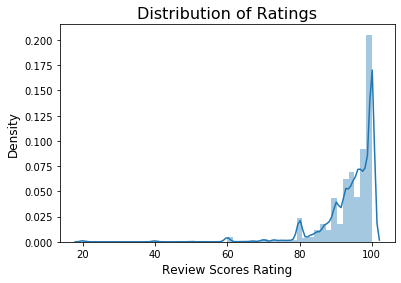

In [24]:
# Histogram for review_scores_rating, a float
sns.distplot(df_imputed['review_scores_rating'])
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Review Scores Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)

Plotting the ratings reveals a long left tail, with most ratings concentrated in the 80-100 score range. This is likely due to AirBnb's rating system, where guests rate their stay on a scale of 1 to 5 stars. Furthermore, properties that fall below a certain rating average get delisted. Combined, this likely results in an artificially biased sample where consistently strong performers are overrepresented. This is explored further in a later section.

Text(0, 0.5, 'Density')

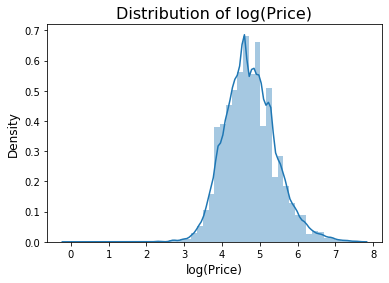

In [25]:
sns.distplot(df_imputed['log_price'])
plt.title('Distribution of log(Price)', fontsize=16)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Density', fontsize=12)

Plotting the log(price) reveals a slight left tail, but otherwise presents a normal distribution. The distribution is centered at the mean value of 4.749232 which translates to roughly $115 with a standard deviation of roughly 2 U.S. dollars. We can proceed with confidence that the normality assumption will not be violated when building a linear regression model to predict log(price).

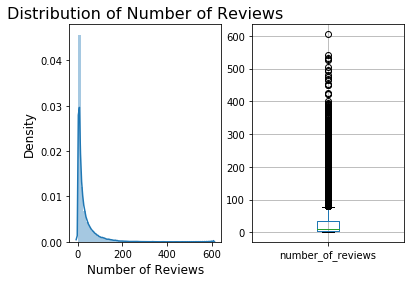

In [26]:
# Histogram
plt.subplot(1,2,1)
sns.distplot(df_imputed['number_of_reviews'])
plt.title('Distribution of Number of Reviews', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Density', fontsize=12)

#BoxPlot
plt.subplot(1,2,2)
df_imputed.boxplot("number_of_reviews")

Plotting the number of reviews reveals a long right tail, with most listings concentrated in the range of 0-33 reviews. This is most likely the result of new listings, and perhaps a rise in popularity of hosts seeking to list their property with AirBnb in recent years. It also informs us that few hosts have been successful in capitalizing on the AirBnB service in these major U.S. cities to date since fewer than 25% of the listings in from this dataset have more than 33 reviews.

Text(0, 0.5, 'Frequency')

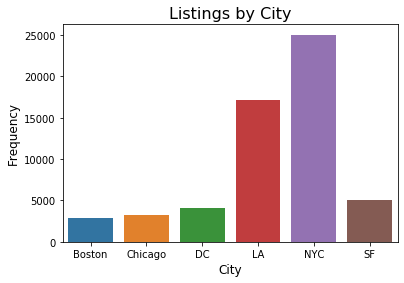

In [27]:
# Bar graph for city, a factor
sns.countplot(x="city", data=df_imputed)
plt.title('Listings by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

This bar graph gets a sense for counts and relative representation in the pared down dataset. Most postings are taken from New York City or Los Angeles, which, combined, constitute nearly 75% of the imputed data. Considering that the six represented are large urban cities, it is possible that any eventual findings may not hold up well in smaller cities or more rural destinations.

Text(0, 0.5, 'Frequency')

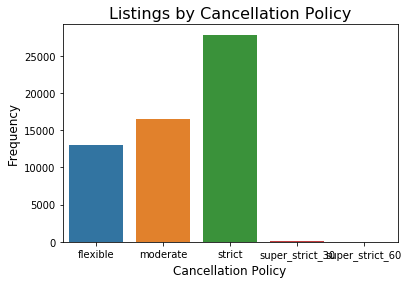

In [28]:
# Bar graph for Cancellation Policy, a factor
sns.countplot(x="cancellation_policy", data=df_imputed)
plt.title('Listings by Cancellation Policy', fontsize=16)
plt.xlabel('Cancellation Policy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

A bar graph of the cancellation policy shows that most listings force a strict cancellation policy, but very few force policies beyond that. Considering that a requirment for "Superhost" status is less than 1% cancellations, it makes sense that more hosts would rather force a strict or moderate cancellation policy over a flexible. This variable is an interesting variable to monitor moving forward with new incoming data because it may have potential role in predicting review score ratings given guests may experience unforeseen circumstances causing them to cancel reservations.

Text(0.5, 1.0, 'Host Has Profile Picture')

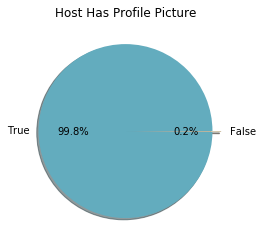

In [29]:
# Pie chart of host_has_profile_pic, a binary variable
explode_profile = (0, 0.1)
labels_profile = ("True", "False")
profile_pics = df_imputed['host_has_profile_pic'].value_counts()
plt.pie(profile_pics, explode=explode_profile, labels=labels_profile,
       autopct='%1.1f%%', shadow=True, colors=('#63ACBE', '#CCBE9F'))
plt.title('Host Has Profile Picture')

While pie charts are oft maligned because it is difficult to visually interpret comparative proportions by size, especially with angles, the problem is not as apparent when only comparing two levels, such as the percentages a binary variable takes.

Seeing a human face on a previously anonymous host could have some effect on whether a disgruntled guest leaves a bad review that brings down a property's rating. (Not all Airbnb guests actually meet the property owner in person during their stay.) However, such a detail likely goes unstudied with this dataset because the overwhelming majority (99.8%) of hosts have a picture on their profile.

Text(0.5, 1.0, 'Host Identity Verified')

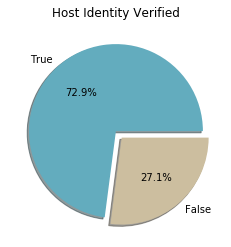

In [30]:
# Pie chart of host_identity_verified
identity_verified = df_imputed['host_identity_verified'].value_counts()
labels_verified = ("True", "False")
explode_verified = (0, 0.1)
plt.pie(identity_verified, autopct='%1.1f%%', explode=explode_verified,
       labels=labels_verified, shadow=True, colors=('#63ACBE', '#CCBE9F'))
plt.title('Host Identity Verified')

However, at least 1/4 of the hosts in this reduced dataset do not have their identity verified. This is rather curious, considering that safety is a two-way street; it would make sense for all parties involved to have their identifications verified.

In [31]:
# Basic exploratory wordcloud for uncleaned amenities, a dict variable of strings
from wordcloud import WordCloud
text = " ".join(amenity for amenity in df_imputed.amenities)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

ModuleNotFoundError: No module named 'wordcloud'

The amenities variable in the dataset likely takes a list of checkmarked items that host select as applicable to their property and turns it into a dictionary object. This basic word cloud takes all amenities in the imputed dataset and generates an image where the most commonly occurring amenities are represented with larger text. The top features properties seem to offer (with similar ones grouped together), include:

* (wireless) Internet to allow people the ability to work or find information about the city they are staying in
* Air conditioning, for the comfort of temperature control
* Smoke and carbon monoxide detectors, safety features that provide peace of mind against dangerous situations

Note that without cleaning, there are stray strings that don't provide any useful information, such as "translation missing."

## Explore Joint Attributes

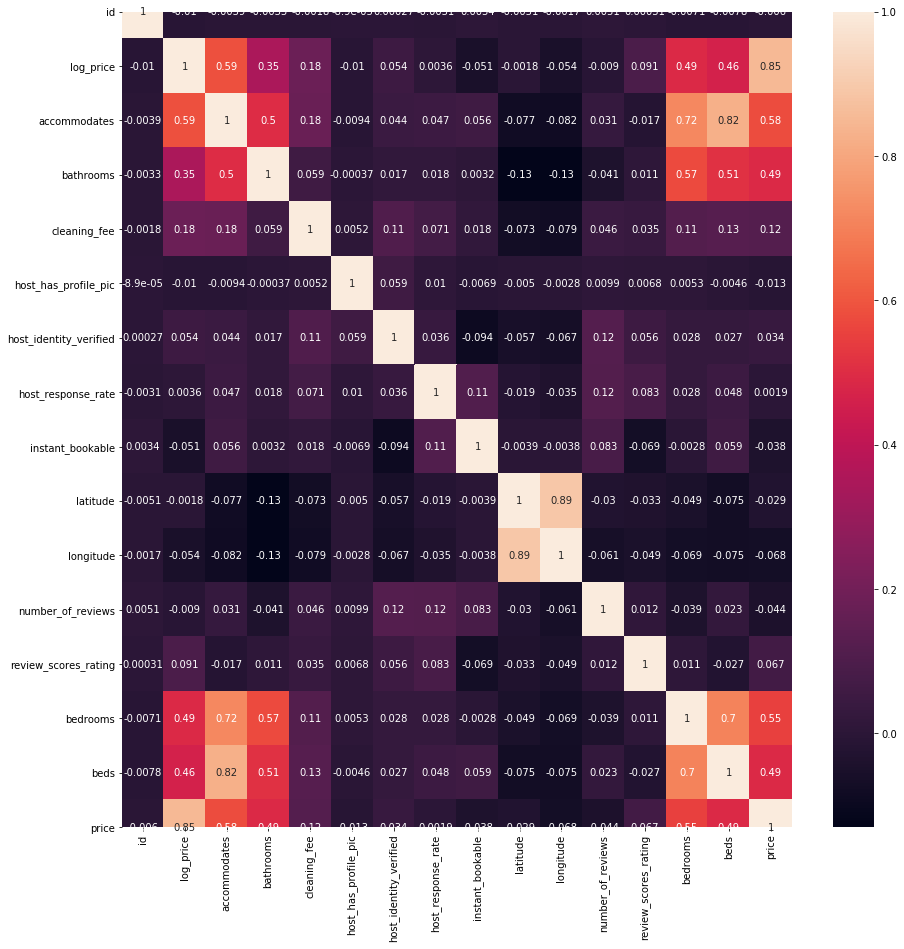

In [32]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15)) 
corr = df_imputed.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True,
           ax=ax)

A heatmap of all the attributes reveals a few positive correlations between certain attributes. For example, the accommodation counts correlate positively with bed count, bathroom count, and bedroom count. This makes logical sense as a listing which accommodates more customers would naturally need more space for said customers. There is also some correlation (0.59) between log price and accommodation. Let's try a deeper dive by creating some more specific correlation plots.

**NOTE: Our decision to impute the missing values for host response rate based on the number of reviews is supported by the fact that it was the most correlated variable. However, it does not present a strong correlation with the host response rate with a value of only 0.12.**

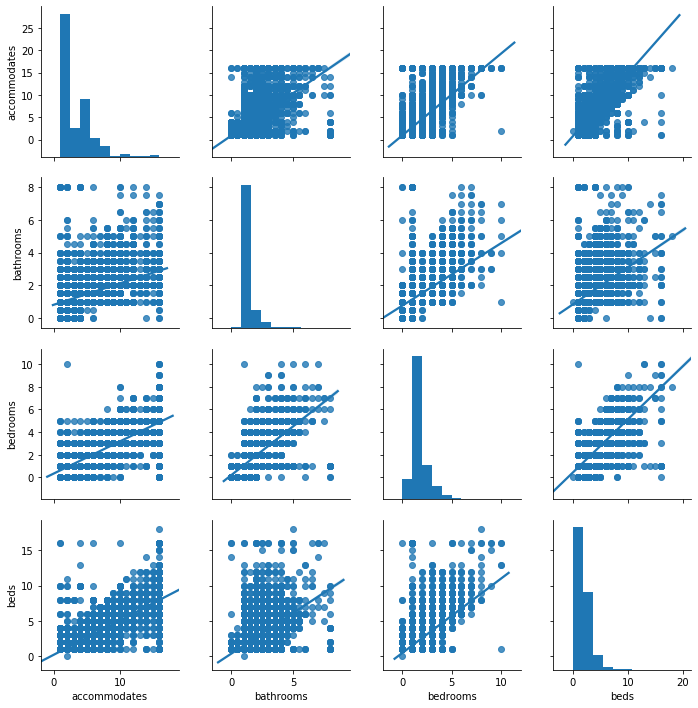

In [33]:
# Scatterplot Matrix for visualization of accommodates, bathrooms, bedrooms, and beds
sns.pairplot(data = df_imputed, vars = ["accommodates","bathrooms","bedrooms","beds"], kind = "reg")

A deeper look at the relationship with acommodation number presents a better understanding of our imputation method for the missing values in the bathrooms, bedrooms, and beds variables. The scatterplot matrix presents a linear relationship between these variables, suggesting that the number of bathrooms, bedrooms, and beds will increase with the number of people a listing can accomodate. This visualization supports the correlation values of accommodation provided in the heatmap above with 0.5, 0.72, and 0.82 for bathrooms, bedrooms, and beds respectively. We generally found that any listing that accomodates up to 2 people will only provide at most 1 bathrooms, 1 bedroom, and 1 bed.

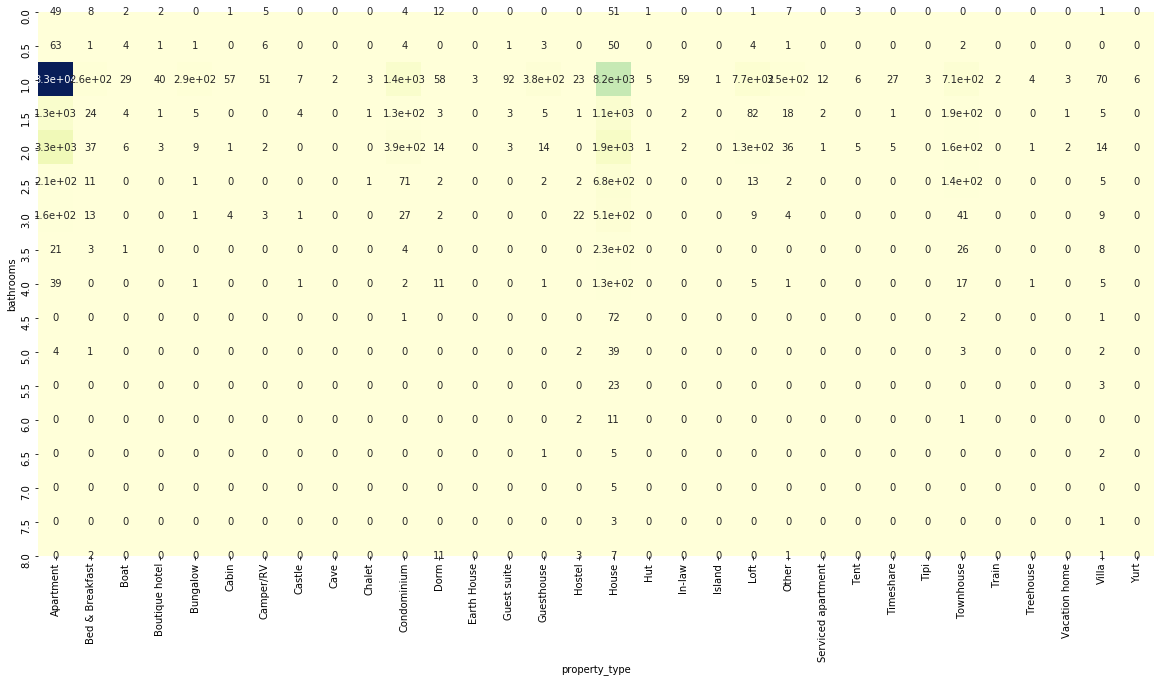

In [34]:
# Cross-Tabulation of Bathrooms with Property Type to provide understanding of Imputation Method
PropertyAccommodates_Bathrooms = pd.crosstab(df_imputed.bathrooms,df_imputed.property_type)
plt.subplots(figsize=(20,10))
sns.heatmap(PropertyAccommodates_Bathrooms, cmap = 'YlGnBu', annot = True, cbar = False)

We additionally accounted for property_type when imputing the missing values for bathrooms, bedrooms, and beds. We believed that the additional space with larger property_types also influenced the number of bathrooms, bedrooms, and beds provided in a listing. For example, house listings are more likely to provide more bathrooms than an apartment listing. A quick look shows that most property_types will provide no more than 4 bathrooms, which supports our decision to impute these missing values based on both accommodation number and property type. 

**Note: We only provided a cross-tabulation visualization on bathroom variable to avoid redundancy with bedrooms and beds since the bathrooms variable had the most missing values. Cross-tabulation visulizations for the other variables can easily be outputted by replacing df_imputed.bathrooms with either df_imputed.bedrooms or df_imputed.beds.**

Text(30.194036458333336, 0.5, 'Latitude')

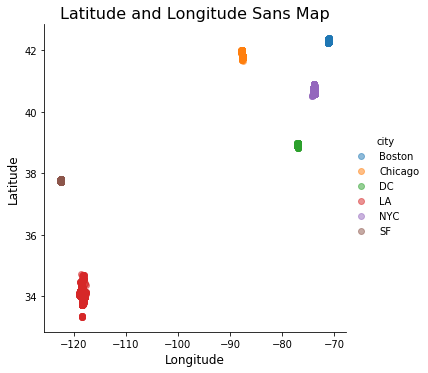

In [35]:
# Scatterplot between latitude and longitude
sns.lmplot(x='longitude', 
            y='latitude',
            data=df_imputed,
           fit_reg=False,
            hue='city',
            scatter_kws={'alpha':0.5})
plt.title('Latitude and Longitude Sans Map', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

While plotting points on an actual map would have been ideal for any visualization with latitude and longitude, a basic scatterplot suffices as a sanity check that the data contained in those two variables correctly correspond to the appropriate city. Points cluster in groups roughly approximating locations on the continental United States--the Californian cities on the West Coast, Chicago in the Midwest, and the remaining three on the East coast--with no color bleed. It could be reasonable to assume that the data does not contain major location-based errors related to any of latitude, longitude, or city.

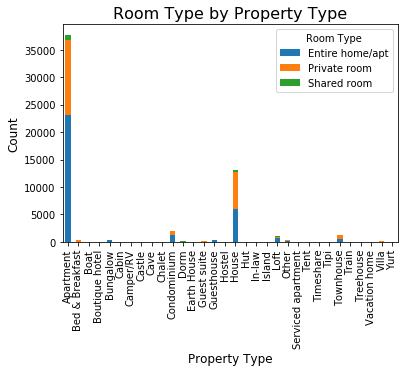

In [36]:
# Stacked bar chart of room and property types
# Note the values argument produces the same counts with any variable
pivot = df_imputed.pivot_table(index='property_type', columns='room_type', 
                               values='beds', aggfunc='count')
pivot.plot.bar(stacked=True)
plt.title('Room Type by Property Type', fontsize=16)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Room Type')

The majority of the properties listed are classified as apartments, with houses in a distant second. Condominiums, lofts, and townhouses round out the other most common property classifications. Considering the dataset discusses six urban cities in the continental US, some of the rare one-off properties such as the castle, yurt, cave, and island (assuming these are accurate property classifications) are somewhat unusual.

In apartments, guests often have free reign over the entire property during their stay. For houses, the policy is about evenly split between access to the entire home versus just a private room.

## Explore Attributes & Class

The target class(es) we are considering in this section are log_price (and its derivative price) and rating, which is involved with superhost.

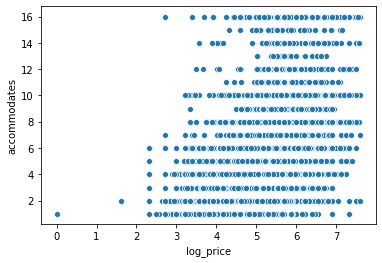

In [37]:
sns.scatterplot('log_price', 'accommodates', data=df_imputed)

Scatter plot of price and accommodations

The price appears to cluster higher for larger accommodations; however, there are some outliers - one value appears to have a price and accommodation of 0.

Earlier we created a host grade attribute, and were examining the impact of verification on the grade. Let's see how grade affects price.

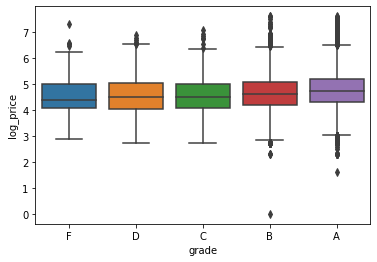

In [38]:
sns.boxplot('grade', 'log_price', data=df_imputed)

The mean price appears to increase with higher grades, but there are a lot of outliers - namely some very low grade hosts with expensive listings, and a few B grade hosts with a price of 0. Let's try intersecting host verification with these same attributes and see how that changes things.

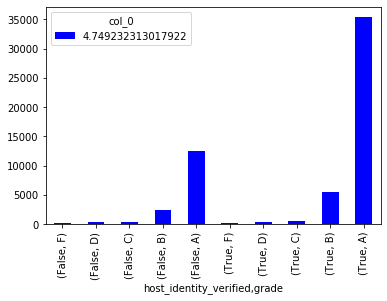

In [39]:
gradeVerify_price = pd.crosstab([df_imputed['host_identity_verified'],df_imputed['grade']], df_imputed.log_price.mean())
gradeVerify_price.plot(kind='bar', stacked=True, color = 'Blue')

Cross-tabulation of grade and verification with price

It appears the interaction of verification and price have an impact on average price. As we saw before, higher grade pulls price averages higher, but verification appears to have much stronger leverage on the overall price. In other words, verified hosts tend to have much higher averaged prices on their listings than unverified hosts. Now let's try the same exercise with city.

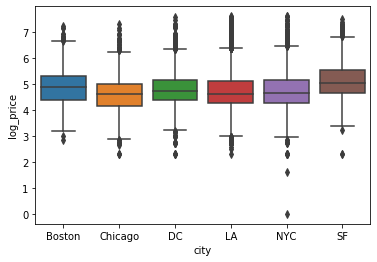

In [40]:
sns.boxplot('city', 'log_price', data=df_imputed)

Again we see the outlier in NYC that has a price of 0. It appears that San Francisco and Boston have the highest average price, with LA and Chicago being the lowest. It's hard to explain why this might be, other than more highly populated cities might have more competition such as other listing services or hotels. Let's try interacting with grade.

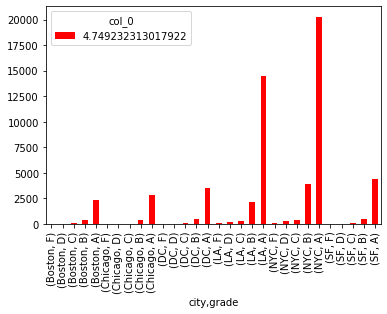

In [41]:
gradeCity_price = pd.crosstab([df_imputed['city'],df_imputed['grade']], df_imputed.log_price.mean())
gradeCity_price.plot(kind='bar', stacked=True, color = 'Red')

Again we see grade has a higher average. Interestingly, the average for each grade appears to be the same across cities except A grades for LA and NYC, which have much higher averages prices than both other grades and other cities. Given what we saw earlier, with these same cities having lower than average overall prices, this indicates that good hosts tend to have highly lucrative listings relative to the rest of the listings in those cities.

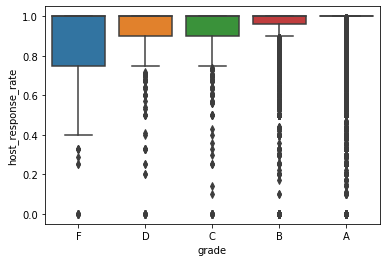

In [42]:
df['host_response_rate'] = df['host_response_rate'].str.strip('%').astype('float')/100.0
sns.boxplot(data=df, x='grade', y='host_response_rate')

A boxplot of response rate against grade shows that the majority of hosts with an 'A' have a perfect or near-perfect response rate. Lower grades are associated with lower response rates.

Text(0, 0.5, 'Number of Reviews')

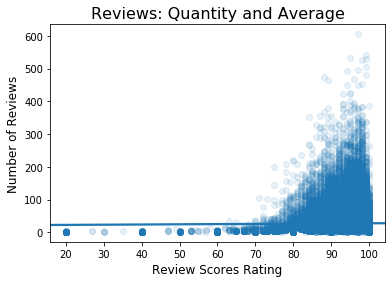

In [43]:
# Scatterplot between rating and number of reviews
sns.regplot(x='review_scores_rating', 
            y='number_of_reviews',
            data=df_ratings,
            scatter_kws={'alpha':0.1})
plt.title('Reviews: Quantity and Average', fontsize=16)
plt.xlabel('Review Scores Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

Due to the sheer amount of data, introducing transparency to individual points in the scatterplot helps show some nuance about the distribution. While the concentration of scores in the 70-100 score range is high, there are also darkened overlapping concentrations on the lower end. This is likely an artifact of the 5-star scoring system, which suggests a decent number of properties had an average of 1, 2, 2.5, or 3 stars.

As suggested earlier, properties that maintain high-quality as judged by guests are permitted to remain listed on AirBnB, resulting in said properties continuing to accumulate reviews. While one interpretation is that guests simply filter for highly rated properties, it is more likely that poor performers get a limited opportunity to get their act together before being dropped in order to maintain quality across the site.

In [44]:
np.average(df_ratings['number_of_reviews'], weights=(df_ratings['review_scores_rating'] <= 60))

1.6767676767676767

In [45]:
(df_ratings['review_scores_rating'] <= 60).sum()

693

Some quick calculations show that listings earning 3 stars and below usually had only 1-2 reviews.

Text(0, 0.5, 'Price, USD')

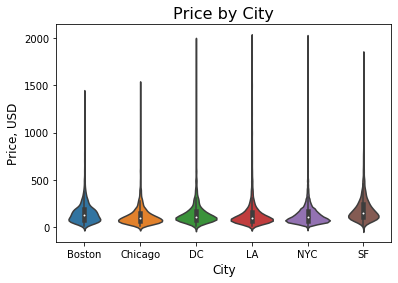

In [46]:
# Violin plots of price by city
sns.violinplot(x="city", y="price", data=df_ratings)
plt.title('Price by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Price, USD', fontsize=12)

Violin plots of untransformed price among the six cities in the dataset reveals long tails caused by the expensive outliers. All six cities have at least one listing going for around \\$1,500 a night. In order to better see the data, we can cut down to a value slightly above the 75th percentile at \\$185.

Text(0, 0.5, 'Price, USD (axis zoomed in)')

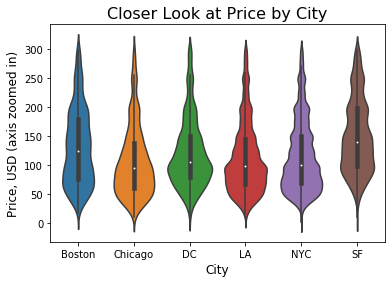

In [47]:
# Violin plots of price by city, removing outliers
sns.violinplot(x="city", y="price", data=df_ratings[df_ratings.price < 300])
plt.title('Closer Look at Price by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Price, USD (axis zoomed in)', fontsize=12)

This view enables us to see the slightly higher price distribution of San Francisco and the higher density of sub-\\$100 postings in New York City, Los Angeles, and Chicago.

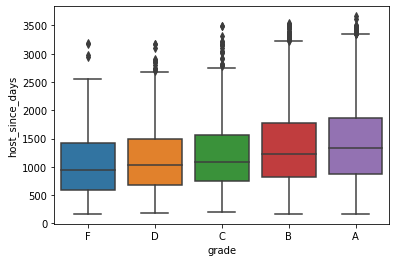

In [48]:
import datetime
date_published = datetime.datetime(2018, 3, 14)
date_published
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_since_days'] = df.apply(lambda row: (date_published - row['host_since']).days, axis=1)
sns.boxplot(data=df, x='grade', y='host_since_days')

The date that a host's property first appeared on the site, the datetime variable host_since, is used to derive host_since_days, which captures the number of days up until March 14, 2018, when the dataset was collected. Higher grades tend to be associated with longer time on the site.

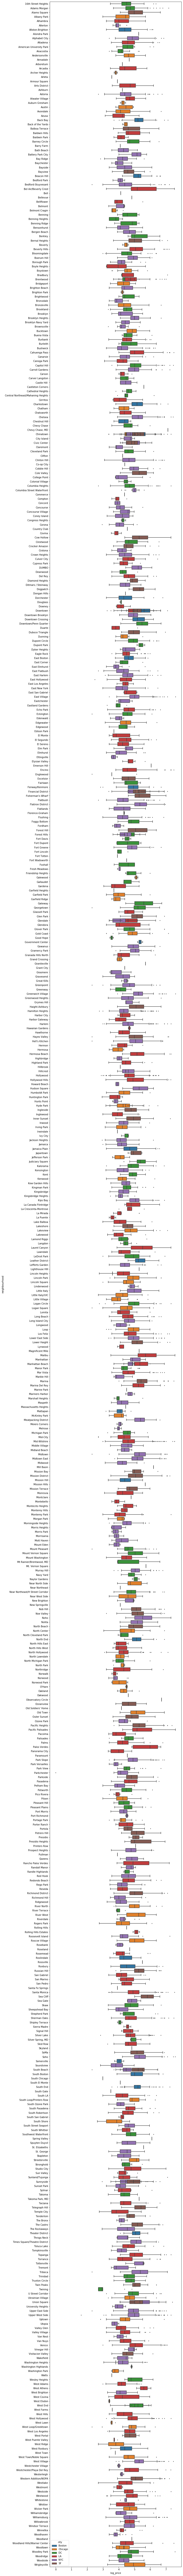

In [49]:
plt.figure(figsize = (10, 200))
sns.boxplot(x="log_price", y="neighbourhood", hue="city", data=df_ratings,
           width=0.8, fliersize=2, dodge=False)

Plotting log(price) against neighborhood names is an easier visualization to handle than using regular price. Of note, some neighborhood names have two or more box colors appear (*e.g.*, Downtown, Chinatown), which makes sense because the same neighborhood name can be shared across different cities.

## New Features

Additional potential features could be engineered from existing attributes or derived from the original AirBnB listings.

* As discussed previously, we dervied the price variable from the original log(price) target variable for easier human interpretation and business relevance.
* We also dervied a grade variable from the review scores as a potential target variable to base a classification model on. A barplot visualization showed a heavy data imbalance favoring A's or ratings above 90%.
    * Based on that finding, we may want to engineer a new feature as the target response variable that a classification model can better discriminate based on the given data. As previously mentioned in the Data Meaning Type section, we will consider a rating score cutoff of 96% as a potential threshold (4.8/5 overall stars). However, this value may be changed to optimize the classification model once we actually begin the training steps. 
* A general sense for the size of the listing could be obtained from principal component analysis on accommodates, bathrooms, bedrooms, and beds. This would also likely need to account for the property and room type factors, which mention what kind and how much of the property is available to guests.
* Clustering could be performed using some combination of latitude, longitude, city, and neighborhood to get a sense for pricing trends based on physical location.
* On a related note, hosts frequently use description and name to advertise a property's proximity to popular tourist destinations, public transportation, or restaurants and nightlife. Sentiment analysis on the significance of a property's physical location could give clues about pricing.
    * For a less subjective alternative, one could bring in the latitude-longitude coordinates of known highlights in a given city and then calculate distance from the property. This could be captured in binary variables, such as whether a property is located within 0.25 miles of a public transport stop or within a city's tourist district.
* Current variables related to reviews are about quantity, scores, or dates. Sentiment analysis could be performed on select reviews (e.g., first, most recent, highest rating, lowest rating) to gain an understanding of why certain guests submitted a given score. For example, perhaps a listing's major strength is its host, and multiple reviews mention the host's hospitality and knowledge about the area. Such details are not currently captured by host-related variables in the dataset. 
    * Review text may also support a host's claims made about proximity in the description and name.

## Exceptional Work

In [50]:
#New attributes by exploring the attributes column
df['internet'] = df.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
print(df[['internet', 'amenities']].head())

df['TV'] = df.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
print(df[['TV', 'amenities']].head())

df['air_conditioning'] = df.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
print(df[['air_conditioning', 'amenities']].head())

df['kitchen'] = df.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
print(df[['kitchen', 'amenities']].head())

df['pool'] = df.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
print(df[['pool', 'amenities']].head())

df['parking'] = df.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)
print(df[['parking', 'amenities']].head())

#We will also make a new price variable that is not logged
df['price'] = np.exp(df['log_price'])

   internet                                          amenities
0      True  {"Wireless Internet","Air conditioning",Kitche...
1      True  {"Wireless Internet","Air conditioning",Kitche...
2      True  {TV,"Cable TV","Wireless Internet","Air condit...
3      True  {TV,"Cable TV",Internet,"Wireless Internet",Ki...
4      True  {TV,Internet,"Wireless Internet","Air conditio...
      TV                                          amenities
0  False  {"Wireless Internet","Air conditioning",Kitche...
1  False  {"Wireless Internet","Air conditioning",Kitche...
2   True  {TV,"Cable TV","Wireless Internet","Air condit...
3   True  {TV,"Cable TV",Internet,"Wireless Internet",Ki...
4   True  {TV,Internet,"Wireless Internet","Air conditio...
   air_conditioning                                          amenities
0              True  {"Wireless Internet","Air conditioning",Kitche...
1              True  {"Wireless Internet","Air conditioning",Kitche...
2              True  {TV,"Cable TV","Wireless Int

In [51]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df['amenities_new'] = df.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df['amenities_new'] = df.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df = df.reset_index()
#Find all the unique amentities in the dataset
total_words = set()
for i in range(len(df['amenities_new'])):
   row = df['amenities_new'][i]
   for entry in row:
       total_words.add(entry)
print(total_words)

{'', 'cooking basics', 'translation missing: en.hosting_amenity_50', 'smartlock', 'family/kid friendly', 'heating', 'beachfront', 'refrigerator', 'outlet covers', 'well-lit path to entrance', 'elevator in building', 'safety card', 'host greets you', 'patio or balcony', 'bathtub with shower chair', 'air purifier', 'other', 'hot water', 'suitable for events', ' smooth pathway to front door', 'lake access', 'beach essentials', 'washer', 'wireless internet', 'toilet paper', 'wide clearance to bed', 'doorman entry', 'flat smooth pathway to front door', 'hair dryer', 'single level home', 'first aid kit', 'stove', 'bath towel', 'dog(s)', 'laptop friendly workspace', 'bathtub', 'waterfront', 'private entrance', 'shampoo', 'game console', 'pets live on this property', 'hangers', 'free parking on street', 'cleaning before checkout', 'luggage dropoff allowed', 'ethernet connection', 'grab-rails for shower and toilet', 'accessible-height bed', 'hot water kettle', 'changing table', 'fire extinguish

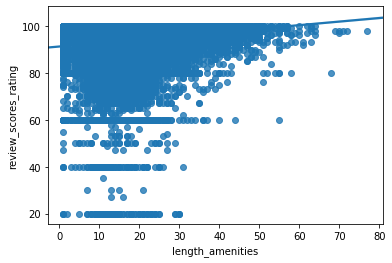

In [52]:
df['length_amenities'] = df.apply(lambda row: len(row['amenities_new']), axis=1)
sns.regplot(x='length_amenities', y='review_scores_rating', data=df)

Perhaps quantity of amenities (or at least those included in a posting) correlates with quality of the property? Longer-length character lists of amenities, which generally corresponds to more amenities, seem to also be related to higher ratings.

We would also like to propose the following items, performed in the above sections, as candidates deserving of exceptional work points:

* The not-so-straightforward imputation strategy to clean out missing values
* Cleanup and exploration of the messy amenities dictionary variable